# Cascade Mask RCNN

In [1]:
!mim download mmdet --config cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco --dest ./checkpoints
!rm -rf ./checkpoints/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py

processing cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco...
cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210719_210311-d3e64ba0.pth exists in /home/ryan/Developer/mmdetection/demo/checkpoints
Successfully dumped cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py to /home/ryan/Developer/mmdetection/demo/checkpoints


In [2]:
import mmcv
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS

register_all_modules()

config_file = '../configs/cascade_rcnn/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py'
checkpoint_file = 'checkpoints/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210719_210311-d3e64ba0.pth'

model = init_detector(config_file, checkpoint_file, device='cuda:0')
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

Loads checkpoint by local backend from path: checkpoints/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210719_210311-d3e64ba0.pth
05/30 23:18:12 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


(427, 640, 3)


/home/ryan/Developer/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


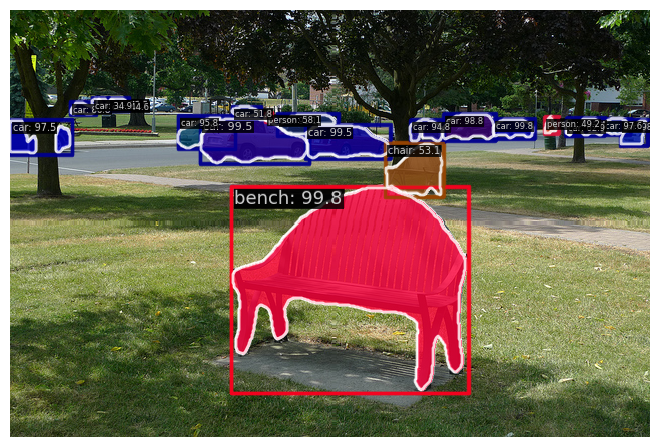

In [3]:
image = mmcv.imread('demo.jpg',channel_order='rgb')
print(image.shape)
result = inference_detector(model, image)
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

To test the model on the whole dataset, `cd` to `mmdetection` home, run

```sh
python  tools/test.py\
        configs/cascade_rcnn/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py\
        projects/ViTDet/checkpoints/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210719_210311-d3e64ba0.pth
```

The config file provides everything for training. There is also a script that handles traing and saves the checkpoint every epoch in `work_dir`.

```sh
python  tools/train.py\
        configs/cascade_rcnn/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py
```

# ViTMAE mmpretrain

https://mmpretrain.readthedocs.io/en/latest/papers/mae.html

In [4]:
import torch
from mmpretrain import get_model

model = get_model('mae_vit-base-p16_8xb512-amp-coslr-300e_in1k', pretrained=True)
inputs = torch.rand(10, 3, 256, 128)
out = model(inputs)
print(len(out))
print(type(out))
print(out[0].shape)
# To extract features.
feats = model.extract_feat(inputs)
print(type(feats))
print(feats[0].shape)
print(torch.allclose(out[0], feats[0]))

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmselfsup/1.x/mae/mae_vit-base-p16_8xb512-fp16-coslr-300e_in1k/mae_vit-base-p16_8xb512-coslr-300e-fp16_in1k_20220829-c2cf66ba.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

1
<class 'tuple'>
torch.Size([10, 129, 768])
<class 'tuple'>
torch.Size([10, 129, 768])
True


In [5]:
h = 480
w = 640
c = 3
b = 1
inputs = torch.rand(b, c, h, w)
out = model(inputs)
print(out[0].shape)

torch.Size([1, 1201, 768])


# sFPN Neck

In [6]:
import mmdet.models.necks.fpn as mmfpn

import torch
in_channels = [2, 3, 5, 7]
scales = [340, 170, 84, 40]
inputs = [torch.rand(1, c, s, s) for c, s in zip(in_channels, scales)]
for i in range(len(inputs)):
    print(f'inputs[{i}].shape = {inputs[i].shape}')
self = mmfpn.FPN(in_channels, 256, len(in_channels) + 1).eval()
outputs = self.forward(inputs)
for i in range(len(outputs)):
    print(f'outputs[{i}].shape = {outputs[i].shape}')

inputs[0].shape = torch.Size([1, 2, 340, 340])
inputs[1].shape = torch.Size([1, 3, 170, 170])
inputs[2].shape = torch.Size([1, 5, 84, 84])
inputs[3].shape = torch.Size([1, 7, 40, 40])
outputs[0].shape = torch.Size([1, 256, 340, 340])
outputs[1].shape = torch.Size([1, 256, 170, 170])
outputs[2].shape = torch.Size([1, 256, 84, 84])
outputs[3].shape = torch.Size([1, 256, 40, 40])
outputs[4].shape = torch.Size([1, 256, 20, 20])


In [7]:
neck = mmfpn.FPN([256, 256, 256, 256], 256, 5)
x = [
        torch.rand(25, 256, 30, 40),
        torch.rand(25, 256, 30, 40),
        torch.rand(25, 256, 30, 40),
        torch.rand(25, 256, 30, 40)
    ]
y = neck.forward(x)
for i in range(len(outputs)):
    print(f'outputs[{i}].shape = {y[i].shape}')

outputs[0].shape = torch.Size([25, 256, 30, 40])
outputs[1].shape = torch.Size([25, 256, 30, 40])
outputs[2].shape = torch.Size([25, 256, 30, 40])
outputs[3].shape = torch.Size([25, 256, 30, 40])
outputs[4].shape = torch.Size([25, 256, 15, 20])


In [8]:
import mmdet.models.necks.simplefpn as sfpn
import torch

my_neck = sfpn.SimpleFPN(768, 256)
x = [torch.rand(25, 768, 30, 40)]
y = my_neck.forward(x)
for i in range(len(x)):
    print(f'inputs[{i}].shape = {x[i].shape}')
for i in range(len(y)):
    print(f'outputs[{i}].shape = {y[i].shape}')


inputs[0].shape = torch.Size([25, 768, 30, 40])
outputs[0].shape = torch.Size([25, 256, 120, 160])
outputs[1].shape = torch.Size([25, 256, 60, 80])
outputs[2].shape = torch.Size([25, 256, 30, 40])
outputs[3].shape = torch.Size([25, 256, 15, 20])
outputs[4].shape = torch.Size([25, 256, 8, 10])


```
python tools/train.py configs/cascade_rcnn/cascade-mask-rcnn_r50_sfpn_1x_coco.py
```

# VitMAE detectron2

In [9]:
import mmdet.models.backbones.vitmae as vitmae
import mmdet.models.backbones.resnet as resnet
from functools import partial
import torch.nn as nn
import torch

embed_dim, depth, num_heads, dp = 768, 12, 12, 0.1
model = vitmae.ViTMAE(
    img_size=1024,
    patch_size=16,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    drop_path_rate=dp,
    window_size=14,
    mlp_ratio=4,
    qkv_bias=True,
    window_block_indexes=[
        # 2, 5, 8 11 for global attention
        0,
        1,
        3,
        4,
        6,
        7,
        9,
        10,
    ],
    residual_block_indexes=[],
    use_rel_pos=True,
    weight_url="detectron2://ImageNetPretrained/MAE/mae_pretrain_vit_base.pth?matching_heuristics=True"
)

resn = resnet.ResNet(
    depth=50,
    num_stages=4,
    out_indices=(0, 1, 2, 3),
    frozen_stages=1,
    norm_cfg=dict(type='BN', requires_grad=True),
    norm_eval=True,
    style='pytorch',
    init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')
)

/home/ryan/Developer/conda/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some model parameters or buffers are not found in the checkpoint:
blocks.0.attn.{rel_pos_h, rel_pos_w}
blocks.1.attn.{rel_pos_h, rel_pos_w}
blocks.10.attn.{rel_pos_h, rel_pos_w}
blocks.11.attn.{rel_pos_h, rel_pos_w}
blocks.2.attn.{rel_pos_h, rel_pos_w}
blocks.3.attn.{rel_pos_h, rel_pos_w}
blocks.4.attn.{rel_pos_h, rel_pos_w}
blocks.5.attn.{rel_pos_h, rel_pos_w}
blocks.6.attn.{rel_pos_h, rel_pos_w}
blocks.7.attn.{rel_pos_h, rel_pos_w}
blocks.8.attn.{rel_pos_h, rel_pos_w}
blocks.9.attn.{rel_pos_h, rel_pos_w}
The checkpoint state_dict contains keys that are not used by the model:
  cls_token
  norm.{bias, weight}


In [10]:
x = torch.rand(2, 3, 480, 640)
print(x.type)
y = model.forward(x)
print(y[0].shape)
z = my_neck.forward(y)
for i in range(len(z)):
    print(f'outputs[{i}].shape = {z[i].shape}')

<built-in method type of Tensor object at 0x7f1272f23900>
torch.Size([2, 768, 30, 40])
outputs[0].shape = torch.Size([2, 256, 120, 160])
outputs[1].shape = torch.Size([2, 256, 60, 80])
outputs[2].shape = torch.Size([2, 256, 30, 40])
outputs[3].shape = torch.Size([2, 256, 15, 20])
outputs[4].shape = torch.Size([2, 256, 8, 10])


In [11]:
y_res = resn.forward(x)
for i in range(len(y_res)):
    print(y_res[i].shape)

torch.Size([2, 256, 120, 160])
torch.Size([2, 512, 60, 80])
torch.Size([2, 1024, 30, 40])
torch.Size([2, 2048, 15, 20])


```
python tools/train.py configs/cascade_rcnn/cascade-mask-rcnn_vitmae_b16_sfpn_1x_coco.py
```